# Laboratorium Nr.6   SUPERMODELING 

Asymilacja danych (data assimilation) do supermodelu 
## 1.Proszę zaznajomić się z załączoną prezentacją dt supermodelowania oraz preprintem. 

### Model

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def predator_prey_ode(t, y, params):
    """
    Defines the ODEs for the predator-prey system.

    Parameters:
    - t: Time
    - y: Current populations [population_A, population_B, population_C]
    - params: A dictionary containing all model parameters.

    Returns:
    - dydt: Derivatives [dA/dt, dB/dt, dC/dt]
    """
    A, B, C = y  # Unpack populations


    # Ensure populations are non-negative
    A = max(0, A)
    B = max(0, B)
    C = max(0, C)
    
    # Determine the most populated species and reduce its hunting efficiency
    most_populated = max(A, B, C)
    hunting_efficiency_factor = 1 - params['hunting_efficiency_reduction'] * (most_populated / (most_populated + 1))

    # Compute derivatives
    dA_dt = params['prey_growth_rate'] * A - hunting_efficiency_factor * params['predation_rate_A_by_B'] * A * B
    dB_dt = (
        -params['mortality_rate_B'] * B +
        hunting_efficiency_factor * params['reproduction_rate_B_from_A'] * A * B -
        hunting_efficiency_factor * params['predation_rate_B_by_C'] * B * C
    )
    dC_dt = (
        -params['mortality_rate_C'] * C +
        hunting_efficiency_factor * params['reproduction_rate_C_from_B'] * B * C -
        hunting_efficiency_factor * params['predation_rate_A_on_C'] * A * C
    )
    return [dA_dt, dB_dt, dC_dt]

### Params

In [2]:
# Define parameters with new hunting efficiency factor
parameters = {
    #A
    'prey_growth_rate': 0.02,                     # Growth rate of Species A (prey)
    'predation_rate_A_by_B': 0.005,               # Base predation rate of Species A by Species B
    
    #B
    'mortality_rate_B': 0.05,                     # Mortality rate of Species B
    'predation_rate_B_by_C': 0.002,               # Base predation rate of Species B by Species C
    'reproduction_rate_B_from_A': 0.01,           # Reproduction rate of Species B from consuming A
    
    #C
    'mortality_rate_C': 0.02,                     # Mortality rate of Species C
    'reproduction_rate_C_from_B': 0.003,           # Reproduction rate of Species C from consuming B
    'predation_rate_A_on_C': 0.0001,               # Predation or harm rate of Species A on Species C
   
    # all
    'hunting_efficiency_reduction': 0.4,          # Reduction factor for most populated species' hunting efficiency

    #initial
    'initial_population_A': 40,                   # Initial population of Species A (prey)
    'initial_population_B': 20,                   # Initial population of Species B (predator 1)
    'initial_population_C': 5,                   # Initial population of Species C (predator 2)
}


### utils

In [3]:
import matplotlib.pyplot as plt

def plot_results(t, pop_A, pop_B, pop_C):
    """
    Plots the results of a predator-prey simulation.

    Parameters:
    - t: Array of time points
    - pop_A, pop_B, pop_C: Population dynamics for Species A, B, and C
    """
    plt.figure(figsize=(12, 7))
    plt.plot(t, pop_A, label='Species A (Prey)', color='green')
    plt.plot(t, pop_B, label='Species B (Predator 1)', color='blue')
    plt.plot(t, pop_C, label='Species C (Predator 2)', color='red')
    plt.xlabel('Time')
    plt.ylabel('Population Size')
    plt.title('Predator-Prey Dynamics with Hunting Efficiency Reduction')
    plt.legend()
    plt.grid()
    plt.show()

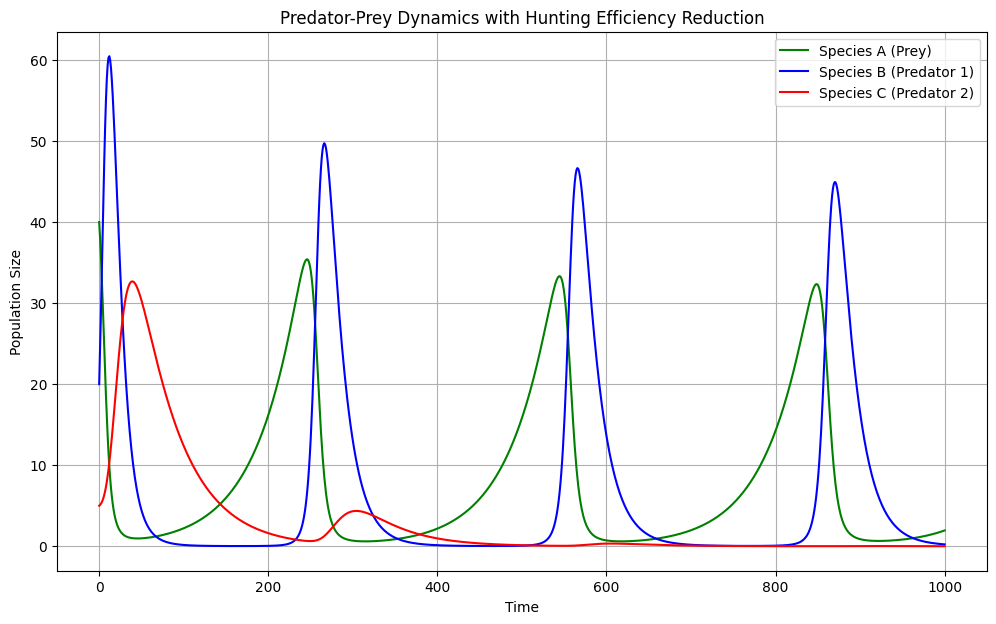

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.001e+00 ...  9.990e+02  1.000e+03]
        y: [[ 4.000e+01  3.815e+01 ...  1.915e+00  1.952e+00]
            [ 2.000e+01  2.401e+01 ...  2.388e-01  2.304e-01]
            [ 5.000e+00  5.092e+00 ...  6.371e-03  6.247e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 501
     njev: 0
      nlu: 0

In [4]:
from scipy.integrate import solve_ivp
import numpy as np


def evaluate_model_and_plot( 
    model, 
    params,
    y_0,
    t_calc_range =(0, 1000),
    t_eval = np.linspace(0, 1000, 1000),
    plot=False
    ):
    solution = solve_ivp(
        fun=lambda t, y: model(t, y, params),
        t_span=t_calc_range,
        y0=y_0,
        t_eval=t_eval,
        method="LSODA"
    )
    if plot:
        plot_results(solution.t, solution.y[0], solution.y[1], solution.y[2])
    return solution

evaluate_model_and_plot(
    predator_prey_ode, 
    parameters, 
    [   
     parameters['initial_population_A'], 
     parameters['initial_population_B'], 
     parameters['initial_population_C']
    ],
    plot=True)

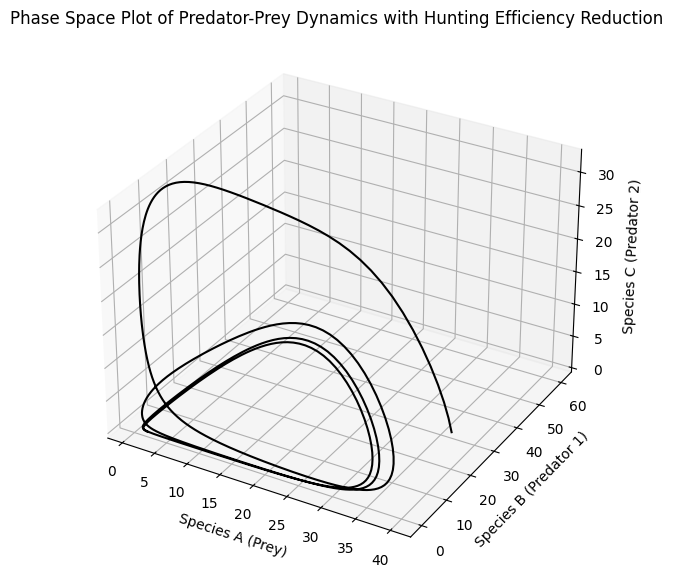

In [5]:
#phase space calc
def phase_space_plot(params):
    sol = evaluate_model_and_plot(
        predator_prey_ode, 
        params, 
        [   
        params['initial_population_A'], 
        params['initial_population_B'], 
        params['initial_population_C']
        ],
        plot=False)

    pop_A = sol.y[0]
    pop_B = sol.y[1]
    pop_C = sol.y[2]

    #phase space plot 3d
    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(pop_A, pop_B, pop_C, color='black')
    ax.set_xlabel('Species A (Prey)')
    ax.set_ylabel('Species B (Predator 1)')
    ax.set_zlabel('Species C (Predator 2)')
    plt.title('Phase Space Plot of Predator-Prey Dynamics with Hunting Efficiency Reduction')
    plt.show()
    
phase_space_plot(parameters)

In [65]:
import pandas as pd
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt

def evaluate_and_compare_parameters(
    params: List[Dict[str, float]],
    t_eval: np.ndarray,
    param_titles : List[str],
    train_t: Optional[Tuple[int, int]] = None
) -> List[np.ndarray]:
    """

    :param params: _description_
    :type params: List[Dict[str, float]]
    :param t_eval: Timestamps on which to evaluate the models and plot them
    :type t_eval: np.ndarray
    :param training_data: _description_
    :type training_data: np.ndarray
    :param param_titles: _description_
    :type param_titles: List[str]
    :param train_t: 
    :type train_t: Tuple[int, int]
    :return: _description_
    :rtype: List[np.ndarray]
    """
    

    if train_t is not None:
        assert t_eval[0] <= train_t[0] and train_t[0] <= train_t[1] and train_t[1] <= t_eval[-1], "Invalid time intervals"
        
    solutions = []
    for i, param in enumerate(params):
        solution = evaluate_model_and_plot(
            predator_prey_ode, 
            param, 
            [   
            param['initial_population_A'], 
            param['initial_population_B'], 
            param['initial_population_C']
            ],
            t_eval=t_eval,
            plot=False
        )
        solutions.append(solution.y)
        
    if train_t is not None:
        intervals = [(t_eval[0], train_t[0], "lightblue"), (train_t[0], train_t[1], "lightgreen"), (train_t[0], t_eval[1], "lightblue")]
    
    line_colors = []
    for i in range(solutions[0].shape[0]):
        f = plt.figure(figsize=(12, 7))
        
        for j, solution in enumerate(solutions):
            line,  =  plt.plot(t_eval, solution[i], label=param_titles[j])
            
            if i == 0:  # Collect colors from the first variable's plot
                line_colors.append(line.get_color())
        
        if train_t is not None:
            for start, end, color in intervals:
                plt.axvspan(start, end, color=color, alpha=0.5)
        plt.xlabel("Time")
        plt.ylabel("Population Size")
        plt.title(f"Population Dynamics of {i}")
        plt.legend()
        plt.grid()
        plt.show()
        
    #calculate rmse for each species with 1st model
    rmse = {}
    for i, title in enumerate(param_titles[1:]):
        rmse[title] = []
        for var in range(solutions[0].shape[0]):
            rmse[title].append(np.sqrt(np.mean((solutions[0][var] - solutions[i+1][var])**2)))

    # Create a DataFrame and assign colors
    print(line_colors)
    color_map = dict(zip(param_titles, line_colors))
    color_map : Dict[str, str]
    rmse_df = pd.DataFrame(rmse)
    

    # Plot grouped bar plot
    plt.figure(figsize=(12, 7))
    bar_width = 0.2
    x = np.arange(len(rmse_df.index))  # Positions for variables

    for idx, model in enumerate(rmse_df.columns):
        plt.bar(
            x + idx * bar_width,
            rmse_df[model],
            bar_width,
            label=model,
            color=color_map[model]
        )

    plt.xlabel("Variables")
    plt.ylabel("RMSE")
    plt.title("RMSE Comparison Across Models and Variables")
    plt.xticks(x + (len(rmse_df.columns) - 1) * bar_width / 2, rmse_df.index)
    plt.legend(title="Models")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    return rmse_df
    

### abc

In [66]:
from scipy.stats import uniform
import numpy as np
from scipy.integrate import solve_ivp
from queue import PriorityQueue

def abc_assimilation(
        observed_data,
        t_eval,  # t_eval - training range
        params_prior,
        num_samples,
        return_n_params=1
    ):
    accepted_params = PriorityQueue()
    rng = np.random.default_rng()  # Use a random number generator for reproducibility
    
    for _ in range(num_samples):
        # Sample parameters from the prior distribution
        sampled_params = {
            key: uniform.rvs(loc=prior[0], scale=prior[1] - prior[0], random_state=rng.integers(1, 1e6))
            for key, prior in params_prior.items()
        }
        
        # Solve the ODE with the sampled parameters
        sol_sim = solve_ivp(
            predator_prey_ode,
            (0, 800),
            [
                sampled_params['initial_population_A'],
                sampled_params['initial_population_B'],
                sampled_params['initial_population_C']
            ],
            args=(sampled_params,),
            method="BDF",
            t_eval=t_eval,
        )

        # Compute the distance between the simulation and observed data
        distance = sum(np.linalg.norm(sol_sim.y[i] - observed_data[i]) for i in range(len(observed_data)))
        accepted_params.put((distance, sampled_params))
    
    if return_n_params == 1:
        # Return the mean of the best 5 parameter sets
        best_params = [accepted_params.get() for _ in range(5)]
        mean_params = {
            key: np.mean([param[1][key] for param in best_params])
            for key in params_prior.keys()
        }
        return mean_params
    else:
        # Return the top `return_n_params` parameter sets
        return [accepted_params.get()[1] for _ in range(return_n_params)]


### 3dvar

In [67]:
from scipy.optimize import minimize


def cost_function_3dvar(
    params_vec,
    observed_data,
    t_eval, # training range
    params_template,
    params_prior,
    var,
):
    params = params_template.copy()
    i = 0
    for key in params:
        params[key] = params_vec[i]
        i += 1

    sol_sim = solve_ivp(
        predator_prey_ode,
        (0, max(t_eval)),
        [ 
            params['initial_population_A'],
            params['initial_population_B'],
            params['initial_population_C']
        ],
        args=(params,),
        t_eval=t_eval,
        method="Radau",
    )

    obs_cost = 0
    if len(sol_sim.y) > 0:
        for j in range(len(observed_data)):
            obs_cost += np.sum(
                (sol_sim.y[j] - observed_data[j][: sol_sim.y[j].shape[0]])
                ** 2
                / var
            )
    else:
        obs_cost = 1e7

    prior_cost = 0
    i = 0
    for key in params:
        mean_prior = (params_prior[key][0] + params_prior[key][1]) / 2
        std_prior = (params_prior[key][1] - params_prior[key][0]) / 6
        prior_cost += ((params_vec[i] - mean_prior) / std_prior) ** 2
        i += 1

    return obs_cost + prior_cost

def _3d_var_assimilation(params_prior, training_sol, training_x = np.linspace(200, 400, 200)):
    std = 1
    params_template = params_prior.copy()
    params_vec_init = [
        uniform.rvs(loc=prior[0], scale=prior[1] - prior[0], random_state=1)
        for prior in params_prior.values()
    ]

    result = minimize(
        cost_function_3dvar,
        params_vec_init,
        args=(
            training_sol,
            training_x,
            params_template,
            params_prior,
            std**2,
        ),
        method="Nelder-Mead",
    )

    estimated_params_3dvar = params_template.copy()
    i = 0
    for key in estimated_params_3dvar:
        estimated_params_3dvar[key] = result.x[i]
        i += 1
    return estimated_params_3dvar
    


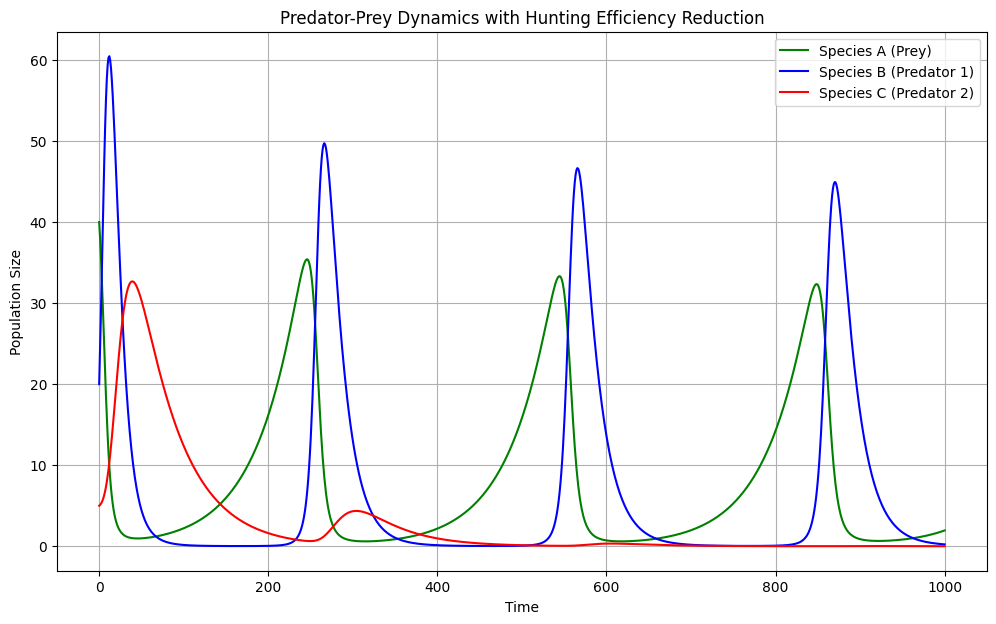

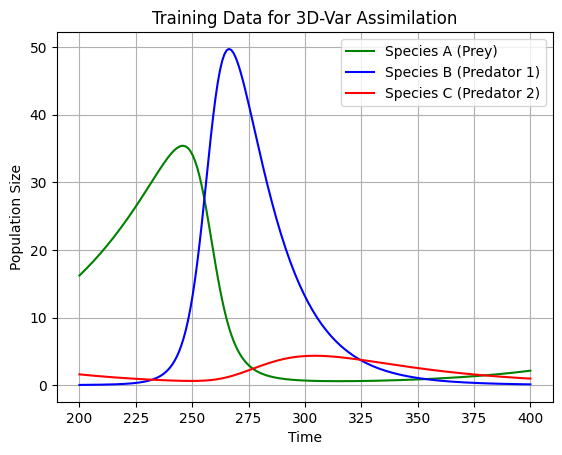

In [68]:
#base model results
base_sol = evaluate_model_and_plot(
    predator_prey_ode, 
    parameters, 
    [   
        parameters['initial_population_A'], 
        parameters['initial_population_B'], 
        parameters['initial_population_C']
    ],
    plot=True
)

training_x = np.linspace(200, 400, 200)
training_sol = base_sol.y[:, 200:400]

plt.plot(training_x, training_sol[0], label='Species A (Prey)', color='green')
plt.plot(training_x, training_sol[1], label='Species B (Predator 1)', color='blue')
plt.plot(training_x, training_sol[2], label='Species C (Predator 2)', color='red')
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Training Data for 3D-Var Assimilation')
plt.legend()
plt.grid()
plt.show()




## 2.W zadaniu wykorzystujemy wyniki z LAB3. Czyli mamy nasz model predator-prey z dobranymi w wyniku asymilacji danych parametrami. Wybieramy jedną z symulacji, która dała dobre wyniki i najmniejszy błąd. Czyli mamy: przedział uczenia z wybranymi próbkami i nauczony (data assimilation) model bazowy z określonym błędem trenowania i predykcji (minimalny błąd na zbiorze testowym). 



### Randomizing starting parameters for models

In [69]:
params_prior = parameters.copy()

for i in params_prior:
    params_prior[i] = params_prior[i] * np.random.uniform(0.5, 1.5)
    
params_search_space = {}
for key in parameters:
    params_search_space[key] = (0.5 * parameters[key], 1.5 * parameters[key])
    
abc_parameters = abc_assimilation(
    training_sol,
    training_x,
    params_search_space,
    40
)
three_dvar_params = _3d_var_assimilation(params_search_space, training_sol, training_x)    


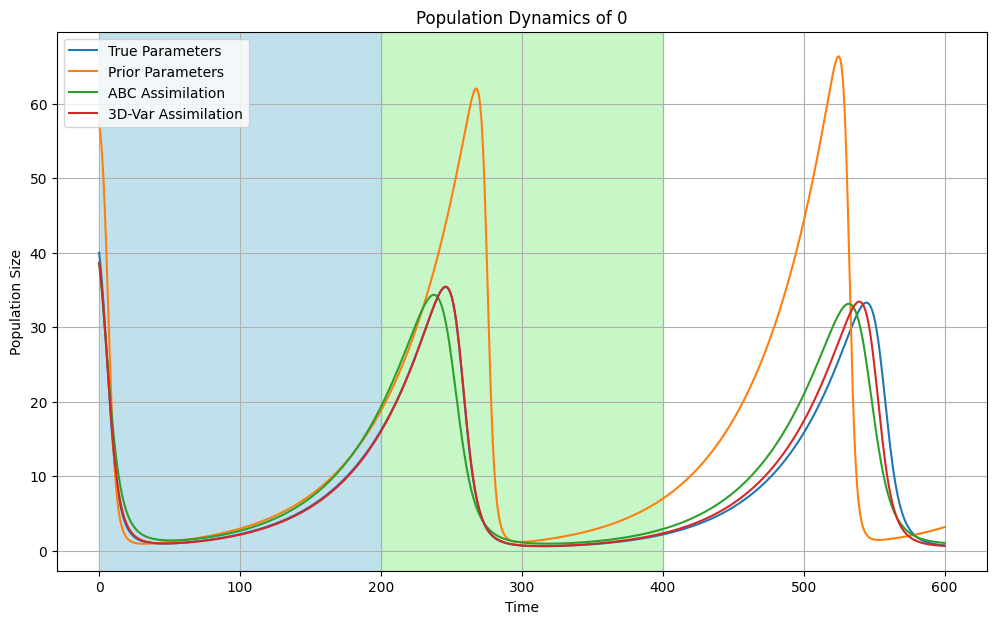

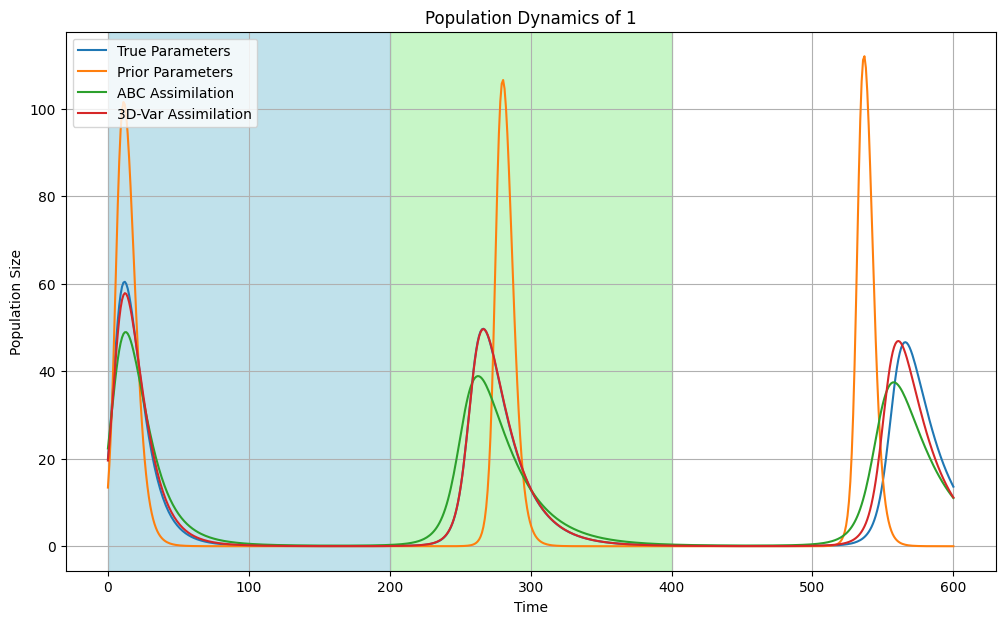

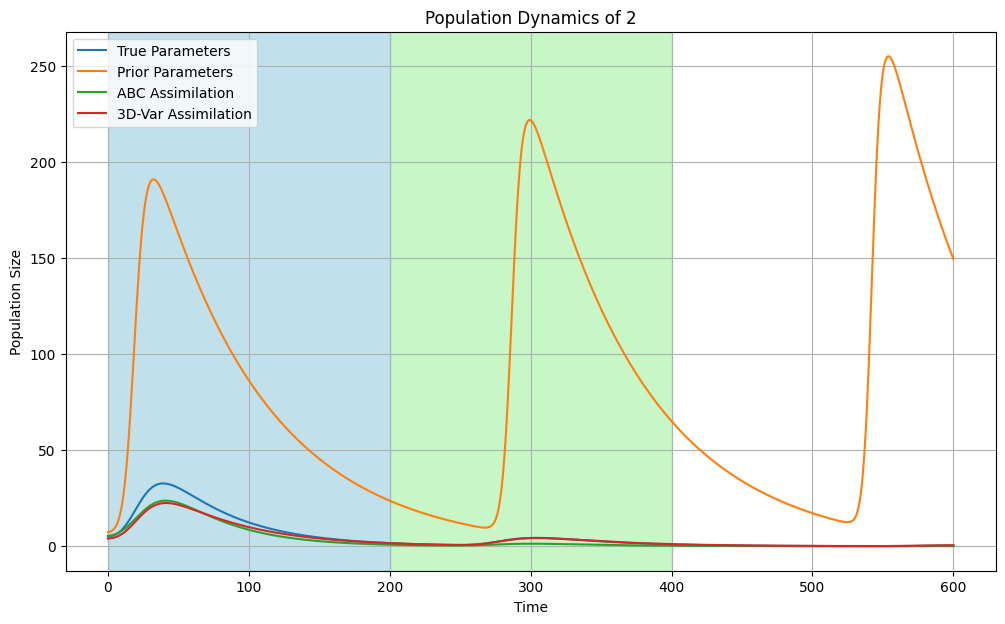

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']


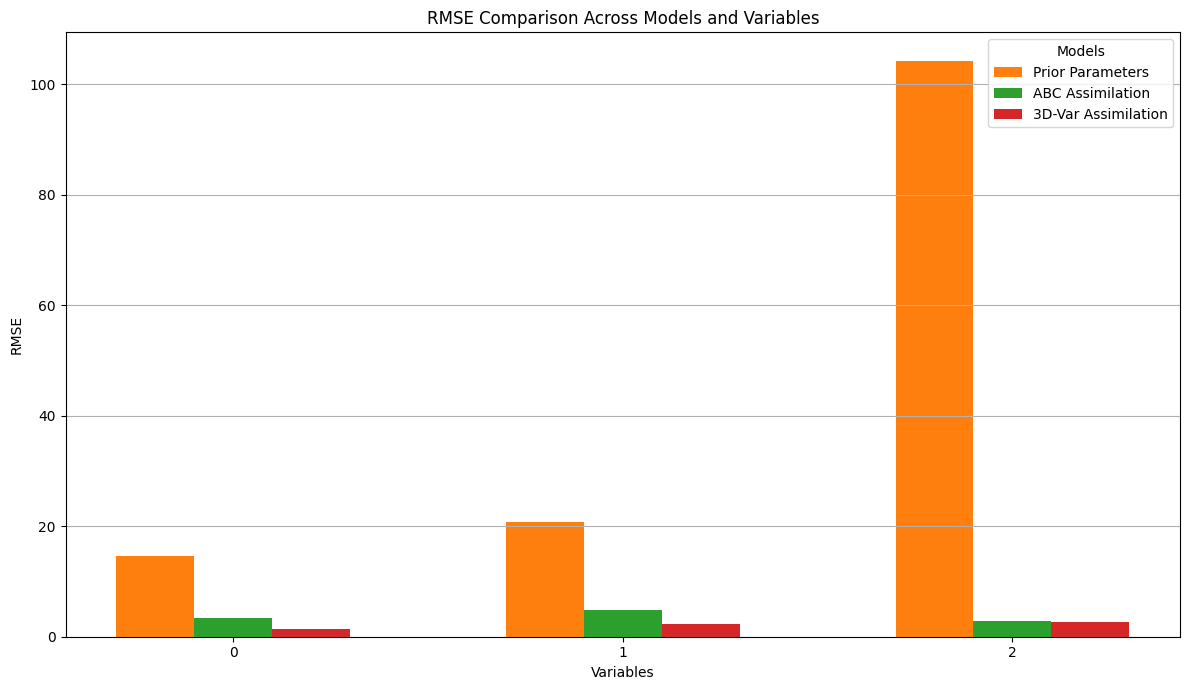

In [71]:
rmse_df_reg_200_400 = evaluate_and_compare_parameters(
    params = [parameters, params_prior, abc_parameters, three_dvar_params],
    t_eval=np.linspace(0, 600, 600),
    param_titles=["True Parameters","Prior Parameters", "ABC Assimilation", "3D-Var Assimilation"],
    train_t=(200, 400)
)

3d var najlepsze wyniki, bo w zasadzie jest bardziej skomplikowana metododa. abc ktory jest praktycznie gridsearchem cos tam znalazl lepszego, ale srednio

In [11]:
import pickle
pickle.dump(abc_parameters, open("abc_parameters.pkl", "wb"))
pickle.dump(three_dvar_params, open("3dvar_parameters.pkl", "wb"))


## 3.Dokonujemy jeszcze raz asymilacji danych, ale tym razem model tylko pretrenujemy w czasie minimum 3 (i więcej) razy krótszym niż czas uczenia modelu bazowego. 


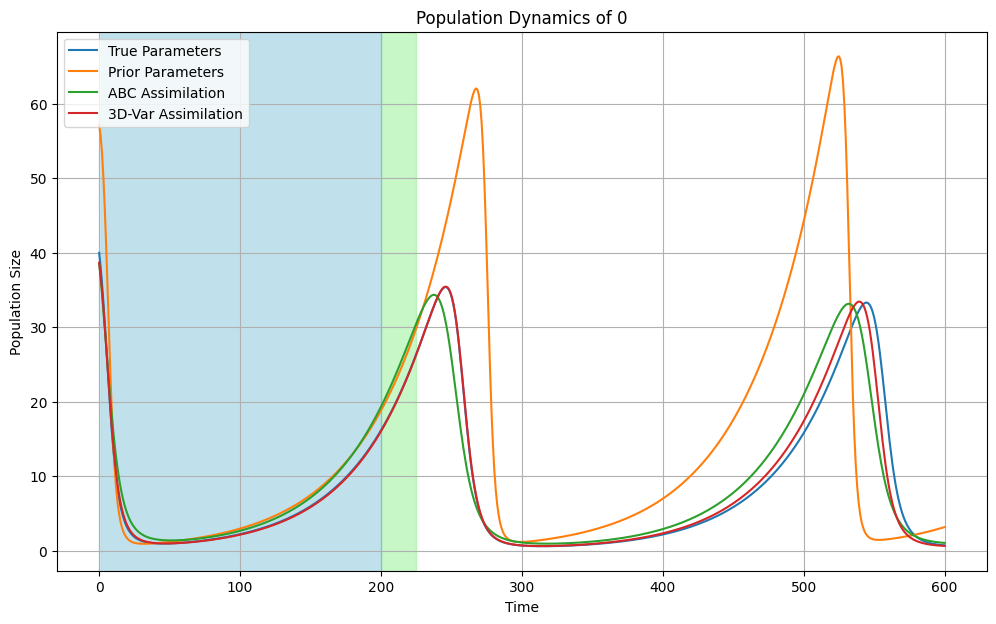

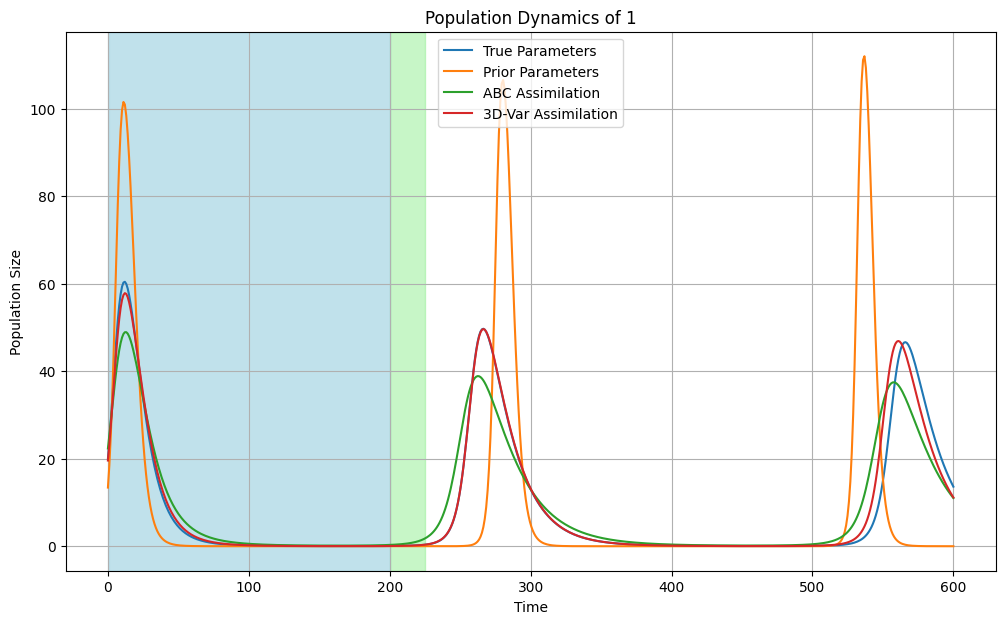

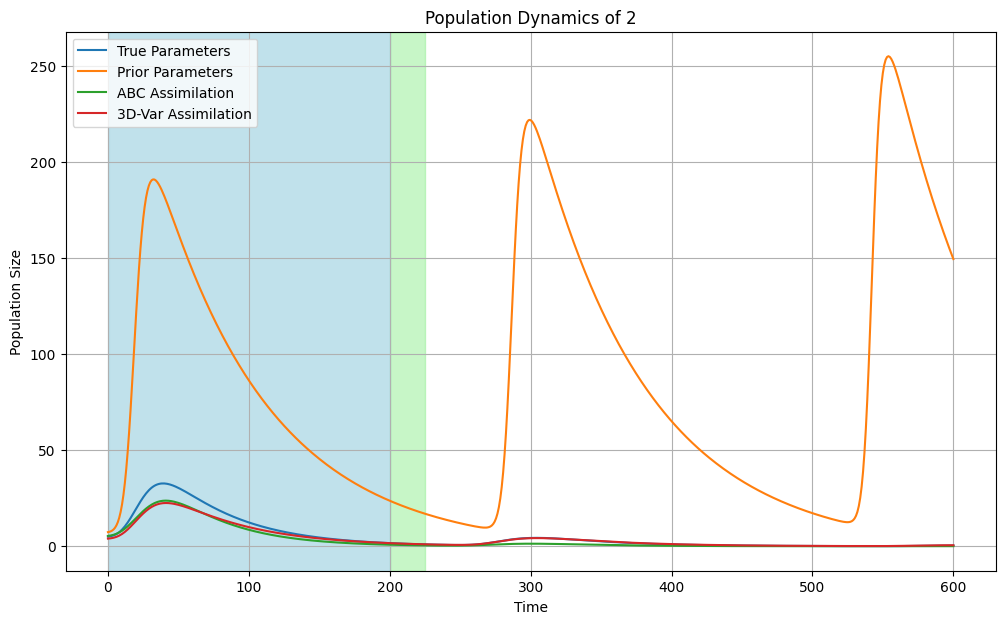

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']


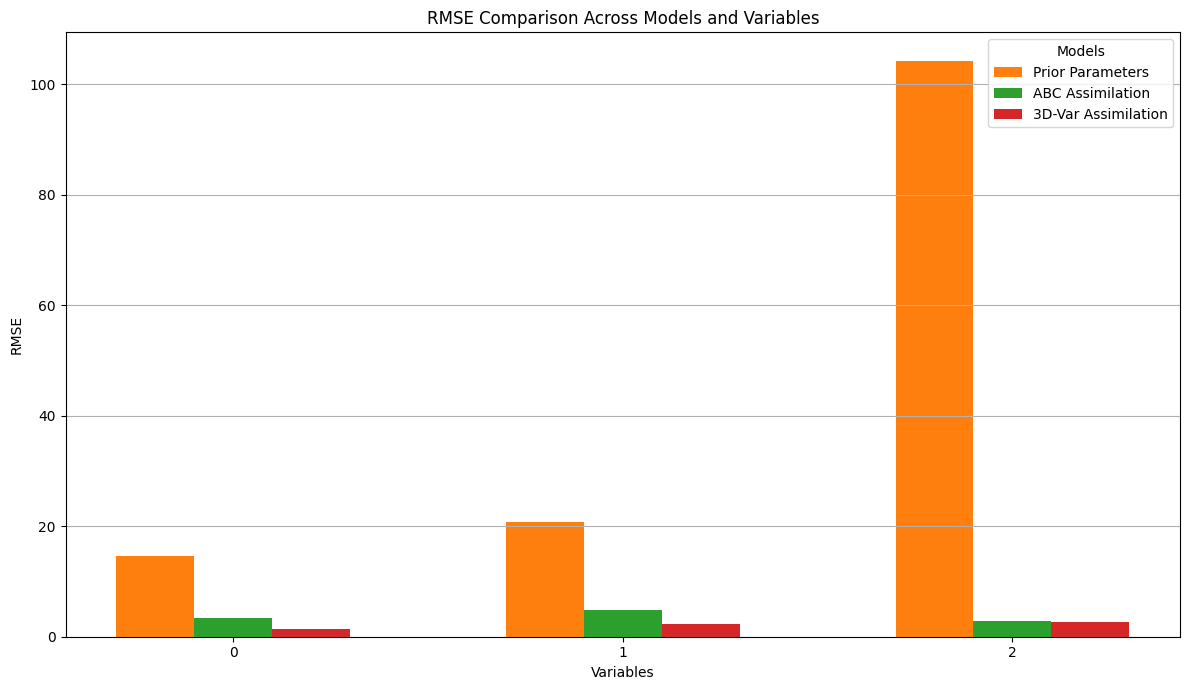

In [72]:
training_sol_short = base_sol.y[:, 200:225]
training_x_short = np.linspace(200, 225, 25)
    
abc_parameters_short = abc_assimilation(
    training_sol_short,
    training_x_short,
    params_search_space,
    40
)
three_dvar_params_short = _3d_var_assimilation(params_search_space, training_sol_short, training_x_short)    


rmse_df_reg_200_225 = evaluate_and_compare_parameters(
    params = [parameters, params_prior, abc_parameters, three_dvar_params],
    t_eval=np.linspace(0, 600, 600),
    param_titles=["True Parameters","Prior Parameters", "ABC Assimilation", "3D-Var Assimilation"],
    train_t=(200, 225)
)

Wziecie krotszego obszaru trenowania mimo wszystko dalo na 3dvar praktycznie idealne wyniki. ABC tez nawet znosne

## 4.W przypadku gdy uczymy go inną metodą niż ABC (3-DVar i inne deterministyczne) tworzymy 3 modele pretrenowane inicjalizując inaczej parametry początkowe. W przypadku stosowania modelu ABC bierzemy 3 najlepsze rozwiązanie po fazie pretreningu. 


wybieram abc, bo 3dvar az za dobrze sie dopasowal i nie ma to sensu specjalnie teraz kombinowac z innymi punktami poczatkowymi

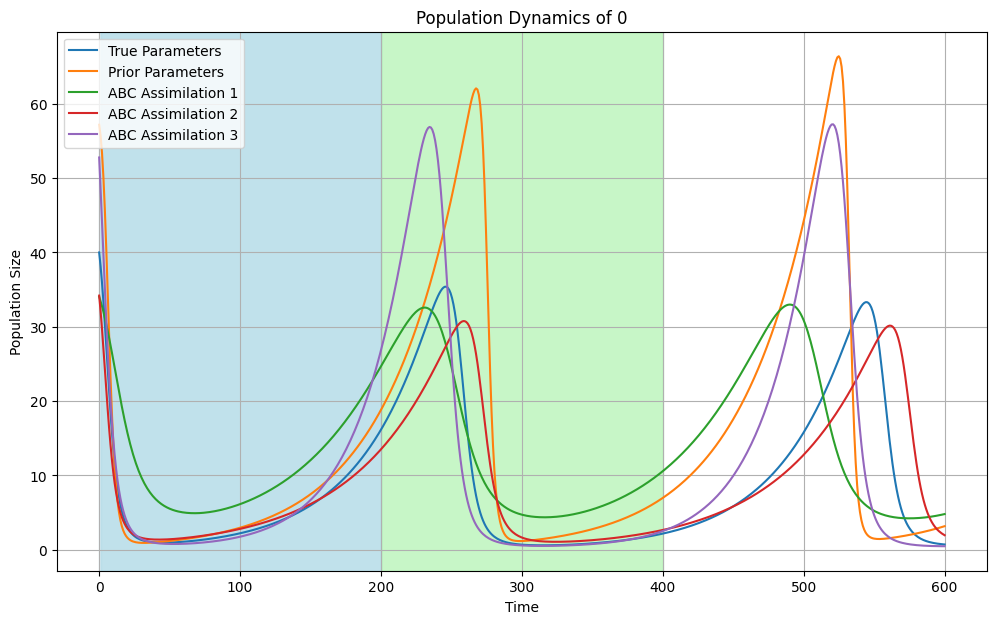

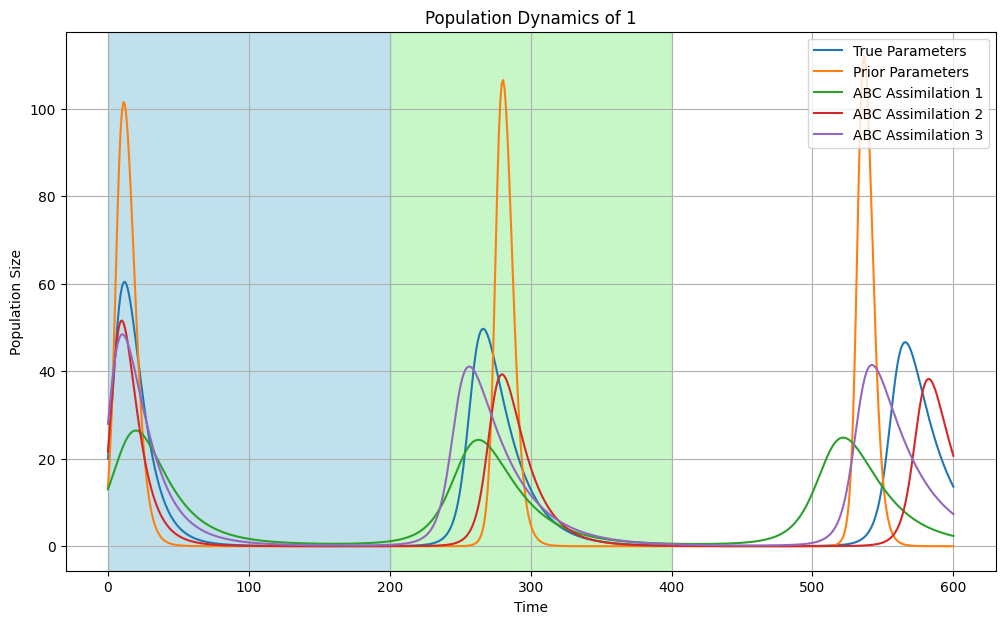

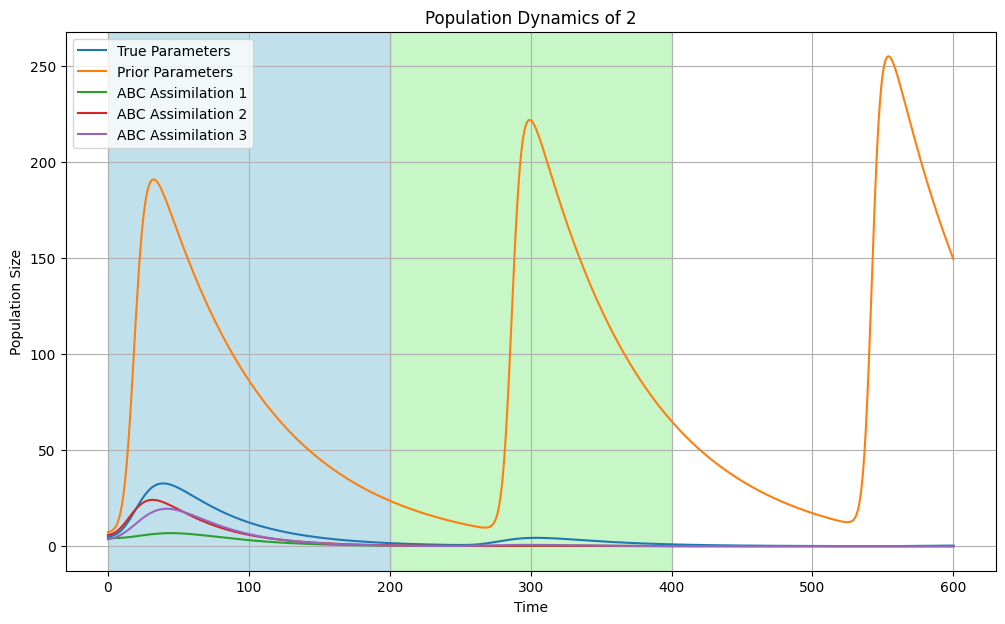

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']


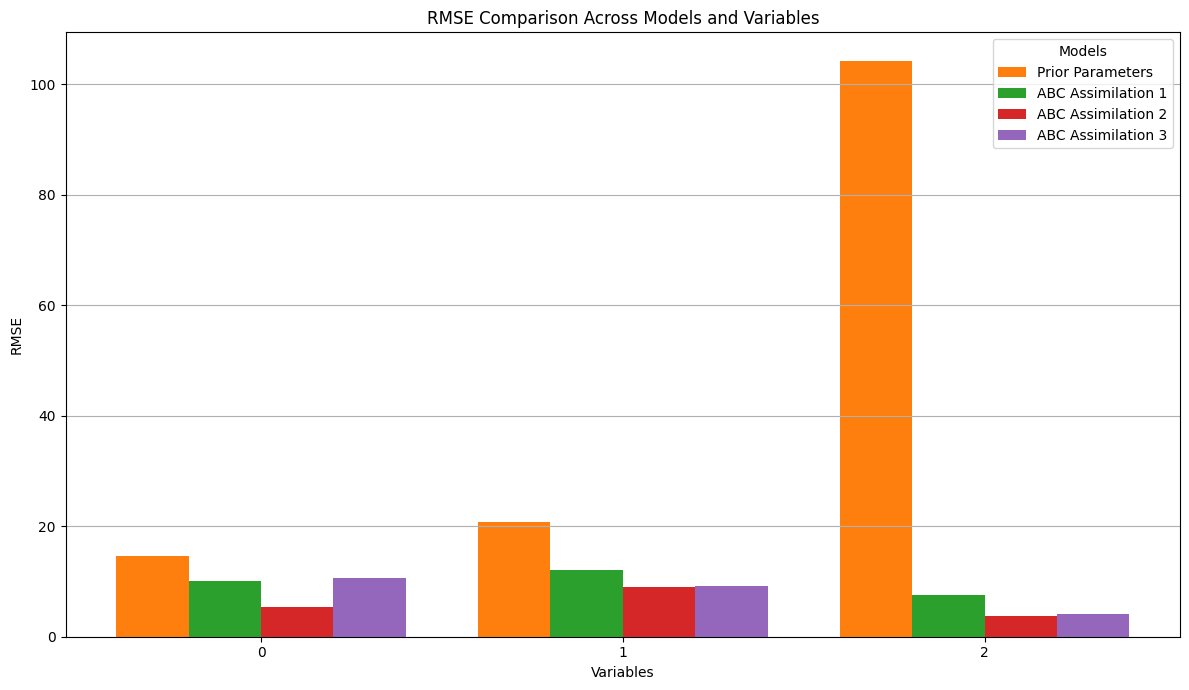

In [73]:
abc_1, abc_2, abc_3 = abc_assimilation(
    training_sol,
    training_x,
    params_search_space,
    40,
    return_n_params=3
)

rmse_df_different_200_400 = evaluate_and_compare_parameters(
    params = [parameters, params_prior, abc_1, abc_2, abc_3],
    t_eval=np.linspace(0, 600, 600),
    param_titles=["True Parameters","Prior Parameters", "ABC Assimilation 1", "ABC Assimilation 2", "ABC Assimilation 3"],
    train_t=(200, 400)
)


## 5.Tworzymy supermodel złożony z tych trzech pretrenowanych podmodeli jak pokazano na załączonej do zadania prezentacji (slajd nr 10). Modele połączone są członami sprzęgającymi, ale tylko względem jednej (najlepiej najczulszej) zmiennej. Proszę też przyjrzeć się animacji na ostatnim slajdzie. Mamy zatem (jak na folii 10) 9 równań w przypadku, gdy Państwa model ma 3 zmienne dynamiczne. Równania są spięte członami sprzęgającymi z współczynnikami C. 


In [32]:
#print all inital coditions
print(abc_1['initial_population_A'])
print(abc_2['initial_population_A'])
print(abc_3['initial_population_A'])
print(abc_1['initial_population_B'])
print(abc_2['initial_population_B'])
print(abc_3['initial_population_B'])
print(abc_1['initial_population_C'])
print(abc_2['initial_population_C'])
print(abc_3['initial_population_C'])

37.1795345879231
28.640559879071095
57.08710447571405
15.807062755830856
28.423564447373327
26.569260878120456
5.906248907082999
5.084610188934053
3.69475165150494


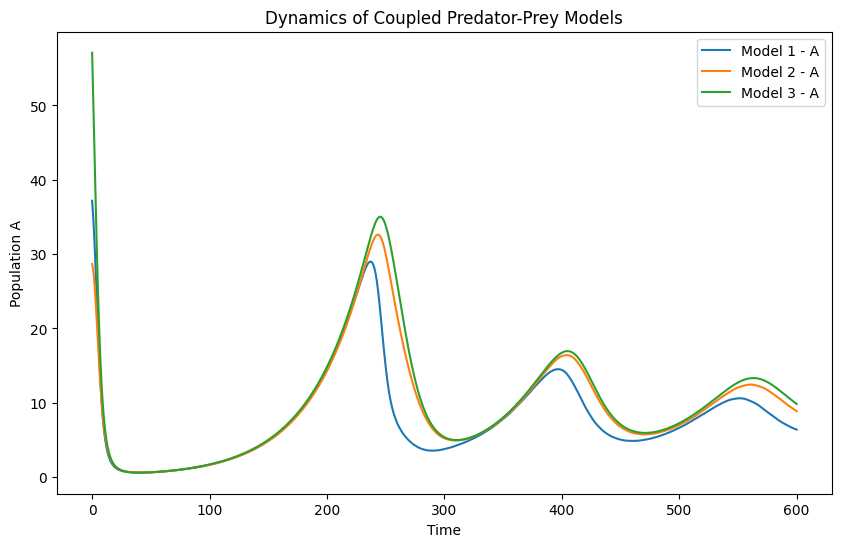

In [34]:
from scipy.integrate import solve_ivp

def coupled_predator_prey_ode(t, y, params_list, C):
    """
    Defines the coupled ODEs for the predator-prey supermodel.

    Parameters:
    - t: Time
    - y: Flattened array of all populations for all models [A1, B1, C1, A2, B2, C2, ...].
    - params_list: List of parameter dictionaries for each model.
    - C: Matrix of coupling coefficients (size: num_models x num_models).

    Returns:
    - dydt: Derivatives for all populations.
    """
    num_models = len(params_list)  # Number of coupled models
    num_vars = 3  # Each model has 3 variables: A, B, C
    
    # Split the flat y vector into individual models
    populations = [y[i:i+num_vars] for i in range(0, len(y), num_vars)]
    
    dydt = []
    
    for m, (A, B, C_pop) in enumerate(populations):
        # Retrieve parameters for the current model
        params = params_list[m]
        
        # Ensure populations are non-negative
        A, B, C_pop = max(0, A), max(0, B), max(0, C_pop)

        # Determine the most populated species in this model
        most_populated = max(A, B, C_pop)
        hunting_efficiency_factor = 1 - params['hunting_efficiency_reduction'] * (most_populated / (most_populated + 1))

        # Compute internal dynamics for this model
        dA_dt = params['prey_growth_rate'] * A - hunting_efficiency_factor * params['predation_rate_A_by_B'] * A * B
        dB_dt = (
            -params['mortality_rate_B'] * B +
            hunting_efficiency_factor * params['reproduction_rate_B_from_A'] * A * B -
            hunting_efficiency_factor * params['predation_rate_B_by_C'] * B * C_pop
        )
        dC_dt = (
            -params['mortality_rate_C'] * C_pop +
            hunting_efficiency_factor * params['reproduction_rate_C_from_B'] * B * C_pop -
            hunting_efficiency_factor * params['predation_rate_A_on_C'] * A * C_pop
        )
        
        # Add coupling terms to dA_dt (only for variable A)
        coupling_term = sum(
            C[m][n] * (populations[n][0] - A) for n in range(num_models) if n != m
        )
        dA_dt += coupling_term
        
        # Append derivatives for the current model
        dydt.extend([dA_dt, dB_dt, dC_dt])
    
    return dydt

# Coupling coefficients matrix
C = np.array([
    [0, 0.1, 0.05],  
    [0.1, 0, 0.07],  
    [0.05, 0.07, 0]  
])

t_eval = np.linspace(0, 600, 600)
t_span = (0, 600)

def run_coupled_sim(param1, param2, param3, C, t_span, t_eval):
    solution = solve_ivp(
        coupled_predator_prey_ode,
        t_span,
        [   
            param1['initial_population_A'], 
            param1['initial_population_B'], 
            param1['initial_population_C'],
            param2['initial_population_A'], 
            param2['initial_population_B'], 
            param2['initial_population_C'],
            param3['initial_population_A'], 
            param3['initial_population_B'], 
            param3['initial_population_C']
        ],
        args=([param1, param2, param3], C),
        t_eval=t_eval,
        method='RK45'
    )
    return solution

solution = run_coupled_sim(abc_1, abc_2, abc_3, C, t_span, t_eval)
# Visualization
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(t_eval, solution.y[i * 3], label=f'Model {i+1} - A')
plt.xlabel('Time')
plt.ylabel('Population A')
plt.title('Dynamics of Coupled Predator-Prey Models')
plt.legend()
plt.show()


Mimo roznych punktow poczatkowych w kazdym z modeli, widac jak sprzezenie zbiega je do siebie w czasie. Probowalem slabszej i mocnijeszej maciezy C i im wyzsze wartosci, tym bardziej zbiegaja do siebie krzywe

## 6.Supermodel trenujemy wybraną metodą asymilacji danych, ale … dobieramy tylko parametry C, pozostałe zostawiamy takie jak policzyły się po pretreningu (patrz animacja na ostatnim slajdzie). Odpowiedź supermodelu to średnia arytmetyczna z odpowiedzi podmodeli (patrz slajdy). 


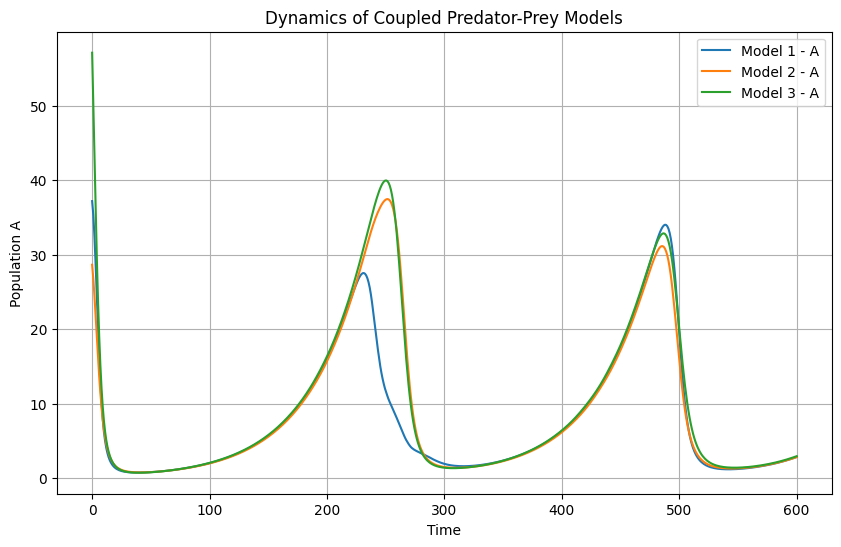

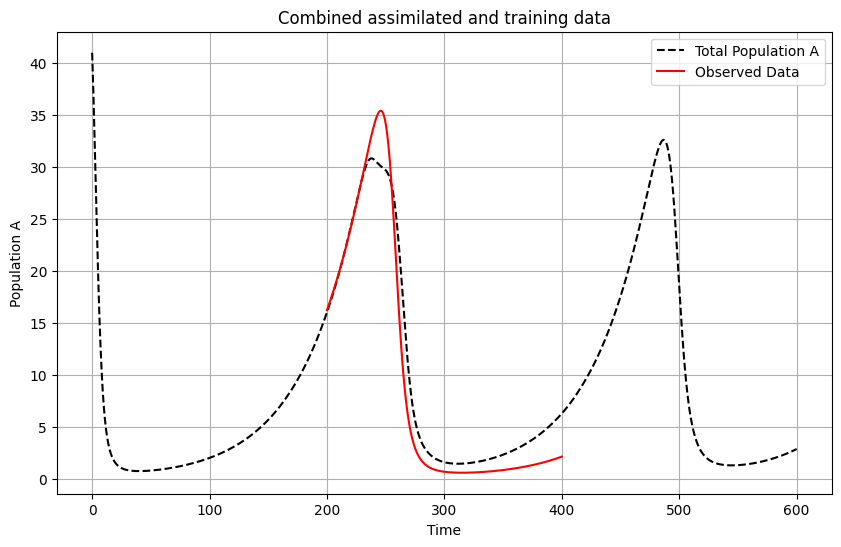

In [52]:
from scipy.stats import uniform
import numpy as np
from scipy.integrate import solve_ivp
from queue import PriorityQueue

def abc_assimilation_coupled(
        observed_data,
        t_eval,  # t_eval - training range
        params_prior,
        C_initial,
        num_samples,
        return_n_params=1
    ):
    """
    Performs ABC assimilation to optimize coupling matrix C for the coupled model.

    Args:
    - observed_data: The observed data for model variable A.
    - t_eval: Time steps for simulation.
    - params_prior: The prior distribution for C, a dictionary of min and max bounds for each coupling coefficient.
    - C_initial: Initial coupling matrix (use this as the starting point for the ABC process).
    - num_samples: Number of samples to draw in the ABC algorithm.
    - return_n_params: Number of best parameter sets to return.

    Returns:
    - Best coupling matrix C that minimizes the difference between simulation and observed data.
    """
    accepted_params = PriorityQueue()
    rng = np.random.default_rng()  # Use a random number generator for reproducibility
    
    # Run ABC assimilation process
    for _ in range(num_samples):
        # Sample coupling coefficients from the prior distribution
        sampled_C = np.array([
            [uniform.rvs(loc=params_prior[i][0], scale=params_prior[i][1] - params_prior[i][0], random_state=rng.integers(1, 1e6)) for i in range(len(params_prior))]
            for _ in range(len(C_initial))
        ])

        # Solve the coupled model with the new sampled coupling matrix C
        solution = run_coupled_sim(
            abc_1, abc_2, abc_3, 
            sampled_C, (0, 600), t_eval
        )

        # Compute the distance between the simulation (mean of models) and observed data for variable A
        model_A = np.mean([solution.y[i*3] for i in range(len(C_initial))], axis=0)
        distance = np.linalg.norm(model_A - observed_data)

        # Add the distance and sampled C to the priority queue
        accepted_params.put((distance, sampled_C))
    
    # Return the coupling matrix that minimizes the distance
    best_params = [accepted_params.get() for _ in range(return_n_params)]
    mean_C = np.mean([param[1] for param in best_params], axis=0)
    
    return mean_C


C_prior = [[0, 0.2]]*3
C_abc = abc_assimilation_coupled(
    training_sol[0],
    training_x,
    C_prior,
    C,
    40
)
 
#plot
solution = run_coupled_sim(abc_1, abc_2, abc_3, C_abc, t_span, t_eval)
# Visualization
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(t_eval, solution.y[i * 3], label=f'Model {i+1} - A')
plt.xlabel('Time')
plt.ylabel('Population A')
plt.title('Dynamics of Coupled Predator-Prey Models')
plt.legend()
plt.grid()
plt.show()
    
plt.figure(figsize=(10, 6))
plt.plot(t_eval, (solution.y[0] + solution.y[3] + solution.y[6])/3, label='Total Population A', color='black', linestyle='--')
plt.plot(training_x, training_sol[0], label='Observed Data', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population A')
plt.title('Combined assimilated and training data')
plt.grid()

## 7.Porównać uzyskaną jakość treningu dla supermodelu i modelu bazowego dla różnych czasów pretreningu (bardzo krótki, krótki, średni).  



In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
from scipy.integrate import solve_ivp
from queue import PriorityQueue
from sklearn.metrics import mean_squared_error

def abc_assimilation_coupled(
        training_data, # in shape of t_eval
        t_span,
        t_eval,  # t_eval - training range
        params_prior,
        C_initial,
        num_samples,
        return_n_params=1
    ):
    """
    Performs ABC assimilation to optimize coupling matrix C for the coupled model.

    Args:
    - observed_data: The observed data for model variable A.
    - t_eval: Time steps for simulation.
    - params_prior: The prior distribution for C, a dictionary of min and max bounds for each coupling coefficient.
    - C_initial: Initial coupling matrix (use this as the starting point for the ABC process).
    - num_samples: Number of samples to draw in the ABC algorithm.
    - return_n_params: Number of best parameter sets to return.

    Returns:
    - Best coupling matrix C that minimizes the difference between simulation and observed data.
    """
    accepted_params = PriorityQueue()
    rng = np.random.default_rng()  # Use a random number generator for reproducibility
    
    # Run ABC assimilation process
    for _ in range(num_samples):
        # Sample coupling coefficients from the prior distribution
        sampled_C = np.array([
            [uniform.rvs(loc=params_prior[i][0], scale=params_prior[i][1] - params_prior[i][0], random_state=rng.integers(1, 1e6)) for i in range(len(params_prior))]
            for _ in range(len(C_initial))
        ])

        # Solve the coupled model with the new sampled coupling matrix C
        solution = run_coupled_sim(
            abc_1, abc_2, abc_3, 
            sampled_C, t_span, t_eval
        )

        # Compute the distance between the simulation (mean of models) and observed data for variable A
        model_A = np.mean([solution.y[i*3] for i in range(len(C_initial))], axis=0)
        distance = np.linalg.norm(model_A - training_data)

        # Add the distance and sampled C to the priority queue
        accepted_params.put((distance, sampled_C))
    
    # Return the coupling matrix that minimizes the distance
    best_params = [accepted_params.get() for _ in range(return_n_params)]
    mean_C = np.mean([param[1] for param in best_params], axis=0)
    
    return mean_C


def run_abc_assimilation_and_plot(true_data, true_eval, training_interval, C_prior, C_initial, num_samples, abc_1, abc_2, abc_3):
    """
    Runs ABC assimilation on a coupled predator-prey model, plots the results, and computes RMSE.
    """
    training_data = true_data[training_interval[0]:training_interval[1]]
    training_eval = true_eval[training_interval[0]:training_interval[1]]
    
    t_span = (0,601)
    
    C_abc = abc_assimilation_coupled(
        training_data,
        t_span,
        training_eval,
        C_prior,
        C_initial,
        num_samples
    )
        
    # Run coupled simulation with the optimized C_abc
    solution = run_coupled_sim(abc_1, abc_2, abc_3, C_abc, t_span, t_eval)
    
    # Plot individual populations for each model
    plt.figure(figsize=(10, 6))
    for i in range(3):
        plt.plot(t_eval, solution.y[i * 3], label=f'Model {i+1} - A')
    plt.xlabel('Time')
    plt.ylabel('Population A')
    plt.title('Dynamics of Coupled Predator-Prey Models')
    plt.legend()
    plt.grid()
    plt.show()
    
    
    
    
    # Plot combined population A and compare with observed data
    plt.figure(figsize=(10, 6))
    combined_population_A = (solution.y[0] + solution.y[3] + solution.y[6]) / 3
    #add background color for training interval
    plt.axvspan(training_interval[0], training_interval[1], color='lightblue', alpha=0.5)
    plt.plot(t_eval, combined_population_A, label='Total Population A', color='black', linestyle='--')
    plt.plot(true_eval, true_data, label='Observed Data', color='red')
    plt.xlabel('Time')
    plt.ylabel('Population A')
    plt.title('Combined Assimilated and Observed Data')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(true_data, combined_population_A))
    print(f"RMSE: {rmse}")
    
    return rmse





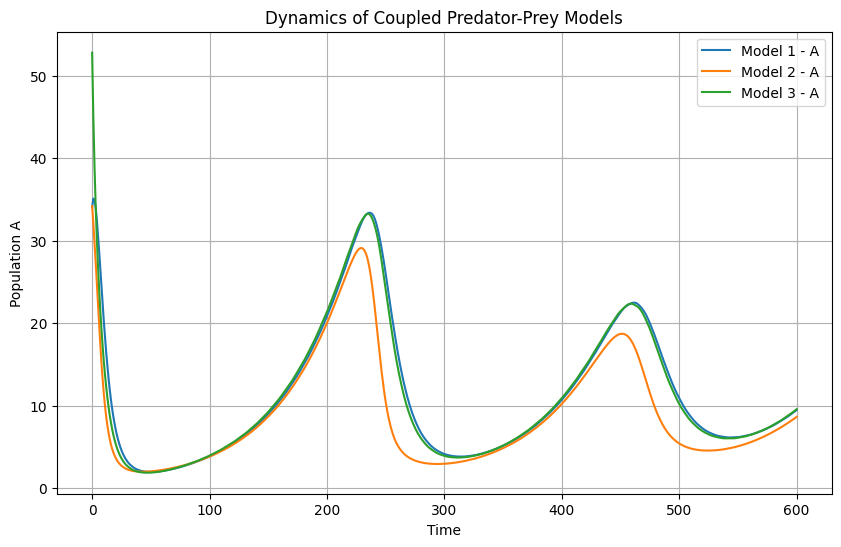

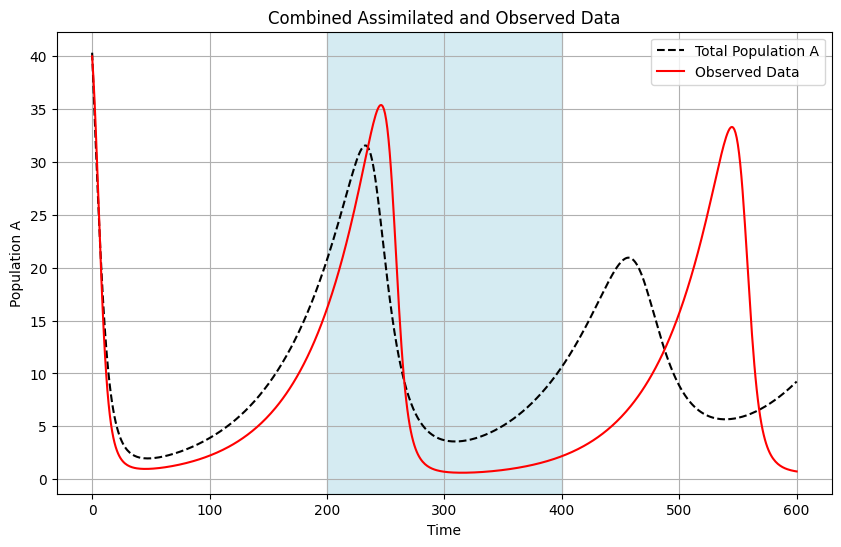

RMSE: 8.603344286555647


np.float64(8.603344286555647)

In [78]:
run_abc_assimilation_and_plot(
    true_data=base_sol.y[0][:600],  # Use your true observed data here
    true_eval=np.linspace(0, 600, 600),
    training_interval=(200, 400),  # Define your training interval
    C_prior=[[0, 0.2]]*3,  # Define prior for C
    C_initial=C,  # Initial coupling matrix
    num_samples=40,  # Number of samples for ABC
    abc_1=abc_1,  # Your model 1 parameters
    abc_2=abc_2,  # Your model 2 parameters
    abc_3=abc_3  # Your model 3 parameters
)

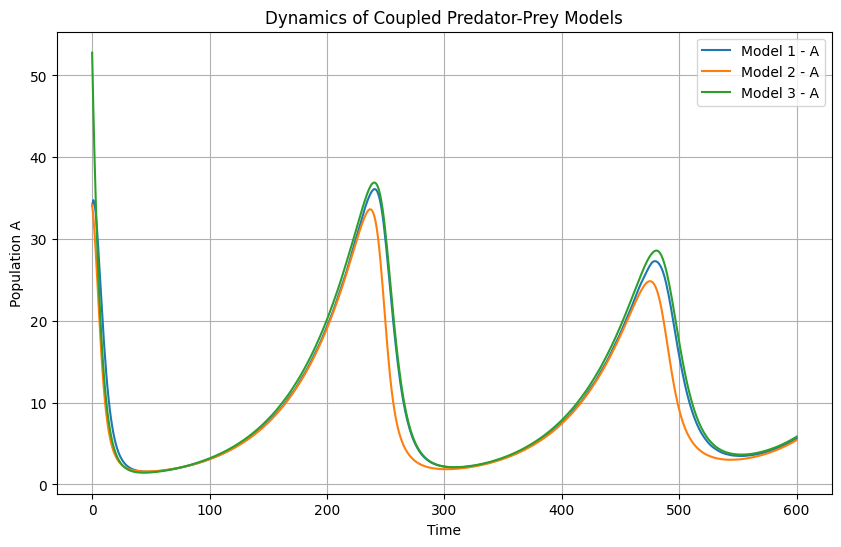

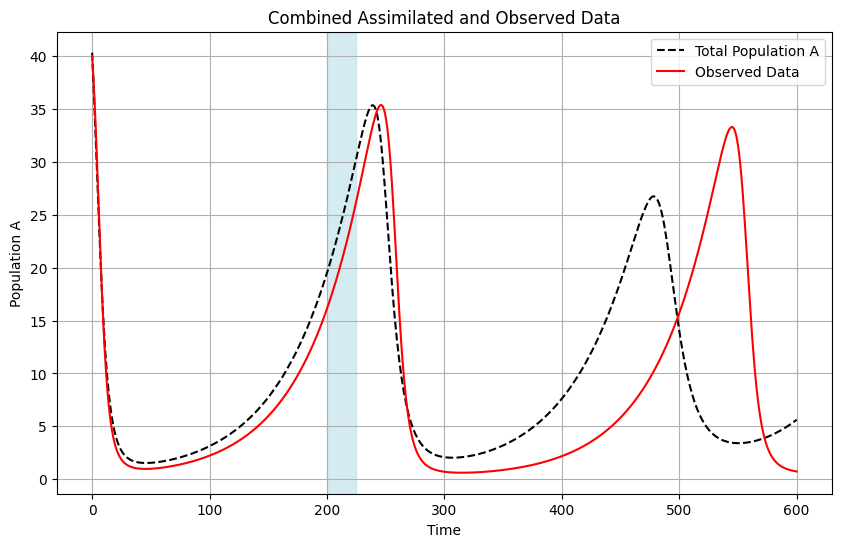

RMSE: 8.620341642226183


np.float64(8.620341642226183)

In [79]:
run_abc_assimilation_and_plot(
    true_data=base_sol.y[0][:600],  # Use your true observed data here
    true_eval=np.linspace(0, 600, 600),
    training_interval=(200, 225),  # Define your training interval
    C_prior=[[0, 0.2]]*3,  # Define prior for C
    C_initial=C,  # Initial coupling matrix
    num_samples=40,  # Number of samples for ABC
    abc_1=abc_1,  # Your model 1 parameters
    abc_2=abc_2,  # Your model 2 parameters
    abc_3=abc_3  # Your model 3 parameters
)

Niezaleznie od przedzialu trenowania wyniki sa bardzo podobne w okolicach 8 rmse.

In [82]:
print(rmse_df_different_200_400.head(1))
print(rmse_df_reg_200_400.head(1))
print(rmse_df_reg_200_225.head(1))

   Prior Parameters  ABC Assimilation 1  ABC Assimilation 2  \
0         14.681034           10.075333            5.346623   

   ABC Assimilation 3  
0           10.690865  
   Prior Parameters  ABC Assimilation  3D-Var Assimilation
0         14.681034           3.30147             1.417613
   Prior Parameters  ABC Assimilation  3D-Var Assimilation
0         14.681034           3.30147             1.417613


porownujac z symulacjami z poprzednich krokow tak dobrany model wspolpracujacy nie sprawdza sie najlepiej, natomiast byly to specjalnie wybrane rozne od siebie modele abc. Mozliwe ze poszerzenie obszaru przeszukiwan C by dalo lepsze rezultaty, lub dobranie dobrze obliczonego 3dvar. Generalnie ciekawa metoda, tym bardziej gdy kazdy z modeli jest obarczony jakims bledem i chcemy w madry sposob skombinowac rozne wyniki. 

## 8.Co się stanie, jeżeli „zepniemy” modele po różnych zmiennych.  

to zadanie juz odpuscilem

Zadanie „warte jest” max 10 punktów. 